# Tutorial 3: Training a Conditional RBM on Timeseries Data

In this tutorial, we train a Conditional RBM (CRBM) on timeseries data. The main task of the model in this setting is to predict the next data frame given a short sequence of previous data frames. 

## The CRBM Model

<img src="img/crbm-general.png" width=400>

As you can see in the image above, besides the bi-directional hidden-visible connections, CRBM has directional connections from its condition data layer to its visible and hidden layers. 

We organize our training data into pairs of condition/output: $\langle c_t, o_t \rangle$. The goal is that, given the conditon, predict the output. In modelling timeseries $D = \{d_1, d_2, ..., d_T\}$, to predict the next data-frame $d_t$, we use a sequence of previous data-frames as the condition: $c_t = \{d_{t-N}, ..., d_{t-2}, d_{t-1}\}$. In this setting, the length of the condition represents the order of the model.

##  The Imports
First, we import the usual `tensorflow`, `numpy`, and `pyplot` packges:

In [107]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

We import the `xrbm.models` module, which contains the `CRBM` model class, as well as the `xrbm.train` module, which contains the `CD-k` approximation algorithm that we use for training our `CRBM`. Also, we use the `xrbm.losses` module contains the utility loss functions that we use to monitor the learning process:

In [2]:
import xrbm.models
import xrbm.train
import xrbm.losses

## Creating the Training Data

To demonestrate using CRBM, we create a simple, artificial 4-dimensional timesries data using sin waves of different frequencies and amplitudes. We add a little bit of noise to this artificial data so that each instance is a bit different from the others.

The main parameter to note here is the `TIMESTEPS`, which represents how many frames the model needs to look at in order to predict the next frame (the model's order). In this example we use 3.

In [3]:
TIMESTEPS = 3

NUM_DIM   = 4
FREQS     = [20, 35, 50, 70]
AMPS      = [4, 1, 0.5, 2.5]
NSAMPLE   = 100
SEQ_LEN   = 2000

time_data = np.arange(SEQ_LEN) / 50

X_train   = []

print('Making dummy time series...')
for i in range(NSAMPLE):
    x = [np.float32(
            np.sin(freq * time_data + np.random.rand()/2) *  
            (amp+np.random.rand())) 
         for freq, amp in zip(FREQS, AMPS)]
    
    x = np.asarray(x)
    x = x + np.random.rand(x.shape[0], x.shape[1]) * 1.2
    
    X_train.append(x.T)

X_train = np.asarray(X_train)

print(X_train.shape)

Making dummy time series...
(100, 2000, 4)


Note that we made 100 series, each with 2000 frames. So, our data (`X_train`) has the shape of `(100, 2000, 4)`. 

Now, let's look at the first 80 frames of the first series in our training data:

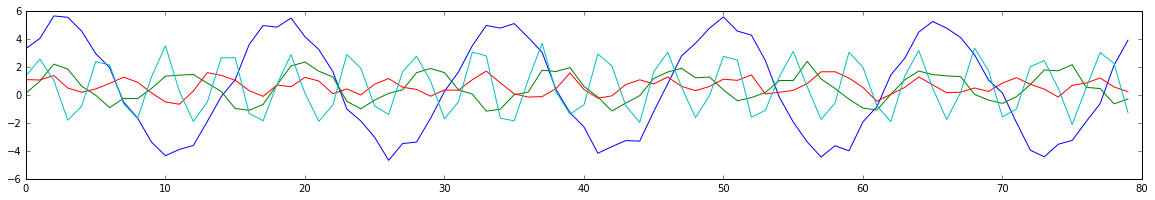

In [4]:
_=plt.figure(figsize=(20,3))
_=plt.plot(X_train[0,0:80,:])

As mentioned before, we added some noise to each sequence. Let's draw each dimension of 5 series individually to get an idea of how much variations we have (not much!):

(-6, 6)

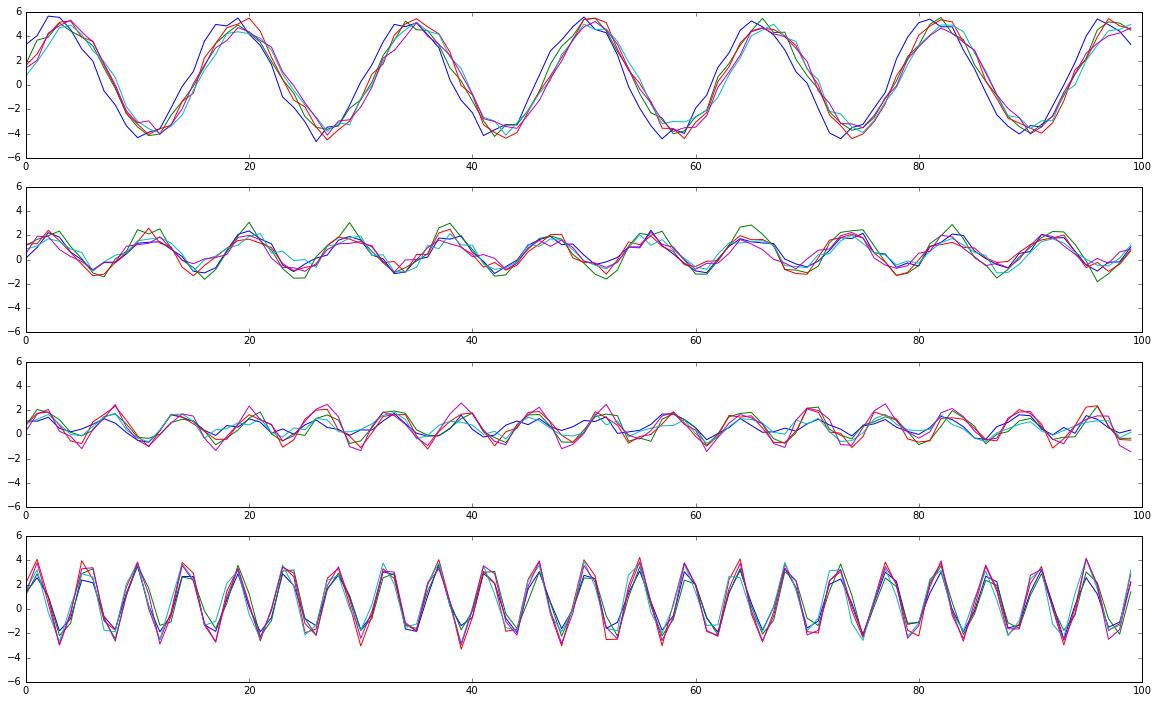

In [5]:
fig=plt.figure(figsize=(20,12))

fig.add_subplot(411)
_=plt.plot(X_train[0:5,0:100,0].T)
plt.ylim(-6, 6)

fig.add_subplot(412)
_=plt.plot(X_train[0:5,0:100,1].T)
plt.ylim(-6, 6)

fig.add_subplot(413)
_=plt.plot(X_train[0:5,0:100,2].T)
plt.ylim(-6, 6)

fig.add_subplot(414)
_=plt.plot(X_train[0:5,0:100,3].T)
plt.ylim(-6, 6)

Before feeding the data to CRBM, we have to normalize it so that it has zero mean and unit variance:

In [6]:
X_train_flat = np.concatenate([m for m in X_train], axis=0)
data_mean = np.mean(X_train_flat, axis=0)
data_std = np.std(X_train_flat, axis=0)

X_train_normalized = [(d - data_mean) / data_std for d in X_train]

We organize the training set into pairs of condition data (the input) and visible data (the output which the model predicts). The condition data has the shape of `(TIMESTEPS, 4)` and the visible data has the shape of `(1, 4)`.

CRBM expects each instance of its condition data to have a shape of `(1, _)`. Therefore, we concatenate (flatten) each sample in the condition data to have the shape of `(1 , 4*3)`.

In [7]:
condition_data = []
visible_data = []

for m in X_train_normalized:
    for i in range(len(m)-TIMESTEPS):
        condition_data.append(m[i:i+TIMESTEPS].flatten())
        visible_data.append(m[i+TIMESTEPS])
        
condition_data = np.asarray(condition_data)
visible_data = np.asarray(visible_data)

## Create a CRBM Instance

We create a CRBM model, set the number of visible, condition, and hidden units. Since our data is real-valued, we set the vis_type to `gaussian`. We also use the Xavier initializer.

In [108]:
num_vis         = visible_data.shape[1]
num_cond        = condition_data.shape[1]
num_hid         = 50
learning_rate   = 0.01
batch_size      = 100
training_epochs = 30

In [109]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

crbm = xrbm.models.CRBM(num_vis=num_vis,
                        num_cond=num_cond,
                        num_hid=num_hid,
                        vis_type='gaussian',
                        initializer=tf.contrib.layers.xavier_initializer(),
                        name='crbm')

We then create the mini-batches:

In [110]:
batch_idxs = np.random.permutation(range(len(visible_data)))
n_batches  = len(batch_idxs) // batch_size

We create a placeholder for the mini-batch data (both conditions and visible data) and the momentum:

In [111]:
batch_vis_data     = tf.placeholder(tf.float32, shape=(None, num_vis), name='batch_data')
batch_cond_data    = tf.placeholder(tf.float32, shape=(None, num_cond), name='cond_data')
momentum           = tf.placeholder(tf.float32, shape=())

We use the CD-k algorithm for training the CRBM. For this, we create an instance of the `CDApproximator` from the `xrbm.train` module and pass the learning rate, momentum, and the number of gibbs iterations to it. 

We then define our training op using the `CDApproximator`'s `train` method, passing the CRBM model and the placeholder for the data. 

In [112]:
cdapproximator     = xrbm.train.CDApproximator(learning_rate=learning_rate,
                                           momentum=momentum,
                                           k=1) # perform 1 step of gibbs sampling

train_op           = cdapproximator.train(crbm, vis_data=batch_vis_data, in_data=[batch_cond_data])

In order to monitor the training process, we calculate the reconstruction cost of the model at each epoch using the cross-entropy loss:

In [113]:
reconstructed_data,_,_,_ = crbm.gibbs_sample_vhv(batch_vis_data, [batch_cond_data])
xentropy_rec_cost  = xrbm.losses.cross_entropy(batch_vis_data, reconstructed_data)

### Creatng a generation loop

Once the model is trained, we can use it to predict the next frame given its previous 3 frames using the `crbm.predict()` method. In order to make things easier, we can create a function that can repeat this operation and generate a new timeseries of arbitrary length. The following function basically takes in 3 dataframes as the initial data, predicts a new data frame, and uses the generated data to predict the next frames. 

In [114]:
def generate(crbm, gen_init_frame = 100, num_gen = 200):
    gen_sample = []
    gen_hidden = []
    initcond = []

    gen_cond = tf.placeholder(tf.float32, shape=[1, num_cond], name='gen_cond_data')
    gen_init = tf.placeholder(tf.float32, shape=[1, num_vis], name='gen_init_data')
    gen_op = crbm.predict(gen_cond, gen_init, 2) # 2 stands for the number of gibbs sampling iterations

    for f in range(TIMESTEPS):
        gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

    print('Generating %d frames: '%(num_gen))

    for f in range(num_gen):
        initcond = np.asarray([gen_sample[s] for s in range(f,f+TIMESTEPS)]).ravel()

        initframes = gen_sample[f+TIMESTEPS-1] 
        
        feed = {gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                gen_init: initframes }
        
        s, h = sess.run(gen_op, feed_dict=feed)

        gen_sample.append(s)
        gen_hidden.append(h)

    gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+TIMESTEPS,num_vis])
    gen_hidden = np.reshape(np.asarray(gen_hidden), [num_gen,num_hid])

    gen_sample = gen_sample * data_std + data_mean
    
    return gen_sample, gen_hidden

Finally, we are ready to run everything and see the results:

In [115]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


#     gen_sample, gen_hidden = generate(crbm, num_gen=70)
#     fig = plt.figure(figsize=(12, 3))
#     _ = plt.plot(gen_sample)
#     display.display(fig)

for epoch in range(training_epochs):

    if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
        epoch_momentum = 0
    else: # once the training is stablized, we use a momentum coeficient of 0.9
        epoch_momentum = 0.9

    for batch_i in range(n_batches):
        # Get just minibatch amount of data
        idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

        feed = {batch_vis_data: visible_data[idxs_i],
                batch_cond_data: condition_data[idxs_i],
                momentum: epoch_momentum}

        # Run the training step
        sess.run(train_op, feed_dict=feed)

    reconstruction_cost = sess.run(xentropy_rec_cost, feed_dict=feed)


    print('Epoch %i / %i | Reconstruction Cost = %f'%
            (epoch+1, training_epochs, reconstruction_cost))

Epoch 1 / 30 | Reconstruction Cost = -3.010691
Epoch 2 / 30 | Reconstruction Cost = -2.966957
Epoch 3 / 30 | Reconstruction Cost = -2.994376
Epoch 4 / 30 | Reconstruction Cost = -2.984589
Epoch 5 / 30 | Reconstruction Cost = -2.984651
Epoch 6 / 30 | Reconstruction Cost = -2.960177
Epoch 7 / 30 | Reconstruction Cost = -2.969611
Epoch 8 / 30 | Reconstruction Cost = -2.975502
Epoch 9 / 30 | Reconstruction Cost = -2.964517
Epoch 10 / 30 | Reconstruction Cost = -2.971733
Epoch 11 / 30 | Reconstruction Cost = -2.981960
Epoch 12 / 30 | Reconstruction Cost = -2.934400
Epoch 13 / 30 | Reconstruction Cost = -2.952061
Epoch 14 / 30 | Reconstruction Cost = -2.949625
Epoch 15 / 30 | Reconstruction Cost = -2.944576
Epoch 16 / 30 | Reconstruction Cost = -2.951761
Epoch 17 / 30 | Reconstruction Cost = -2.960776
Epoch 18 / 30 | Reconstruction Cost = -2.959910
Epoch 19 / 30 | Reconstruction Cost = -2.976897
Epoch 20 / 30 | Reconstruction Cost = -2.957012
Epoch 21 / 30 | Reconstruction Cost = -2.970531
E

Generating 70 frames: 


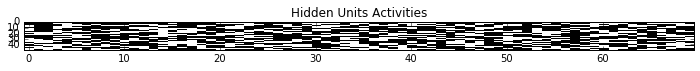

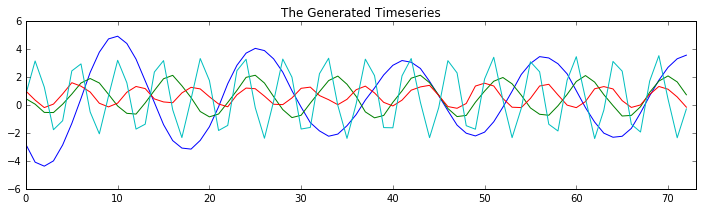

In [116]:
gen_sample, gen_hidden = generate(crbm, num_gen=70)

fig = plt.figure(figsize=(12, 0.5))
_= plt.imshow(gen_hidden.T, cmap='gray', interpolation='nearest', aspect='auto')
plt.title('Hidden Units Activities')

fig = plt.figure(figsize=(12, 3))
_ = plt.plot(gen_sample)        
plt.title('The Generated Timeseries')
plt.xlim(0,73)

sess.close()